#Imports & Settings


In [2]:
! pip install yfinance  backtesting mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 7.8 MB/s eta 0:00:00
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173804 sha256=78089866c0722fee4bb42e5a893ffb2f5121572277fba4741bd23b159d672d48
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 
import mplfinance as fplt 
from backtesting import Backtest , Strategy 
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


#Download CRUDE OIL Data

In [4]:
crude_oil = yf.Ticker('CL=F').history(period='60d',
                                     interval= '15m',
                                     actions=True,auto_adjust=True)
crude_oil_1h = yf.Ticker('CL=F').history(period='60d',
                                     interval= '1h',
                                     actions=True,auto_adjust=True)

#Triple Screen Trading System

* First Screen :  In this System we begin by analysing long term chart as a first screen, in this case we choose hourly chart to identify Major trend using **MACD indicator** and **Exponential MA**. 

* Second Screen :  We use 15 minutes screen during hourly uptrends to identify buying opportunities and during hourly downtrends to identify sell opportunities. We apply **RSI Oscillator** to generate signal, when hourly trend is up we take buy signals generated 15 minutes RSi and vise versa. 

* Third Screen  : we keep 15 minutes chart as third screen for **Stops and Profit Targets**. 

In [5]:
# calculate the Moving Average convergence divergence for first screen analysis 
def macd(x):
    x['short_exp']   = x.Close.ewm(span= 12, adjust= False).mean()
    x['long_exp']    = x.Close.ewm(span= 26, adjust= False).mean()
    x['macd_line']   = x['short_exp']-x['long_exp']
    x['macd_signal'] = x['macd_line'].ewm(span = 9 , adjust= False).mean()
    x['macd_hist']   = x['macd_line'] - x['macd_signal']
    return x  

# calculate the stochastic oscillator for 15 mintues intermediate screen 
def rsi(x):
    diff          = x.Close.diff(1)
    x['Gain']     = diff.clip(lower = 0)
    x['Loss']     = diff.clip(upper = 0).abs()
    x['avr_gain'] = x.Gain.rolling(14).mean()
    x['avr_loss'] = x.Loss.rolling(14).mean()   
    x['RSI']      = 100-(100/(1+(x.avr_gain/x.avr_loss)))
    return x  

In [6]:
oil_macd = macd(crude_oil_1h)
oil_macd.tail(5)  

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_exp,long_exp,macd_line,macd_signal,macd_hist
Datetime,,,,,,,,,,,,
2023-05-09 13:00:00-04:00,72.620003,73.709999,72.480003,73.559998,28683,0.0,0.0,72.638768,72.549418,0.089350,0.083100,0.006251
2023-05-09 14:00:00-04:00,73.559998,73.779999,73.349998,73.589996,36659,0.0,0.0,72.785111,72.626498,0.158613,0.098202,0.060411
2023-05-09 15:00:00-04:00,73.599998,73.639999,73.459999,73.459999,5942,0.0,0.0,72.888940,72.688238,0.200701,0.118702,0.081999
2023-05-09 16:00:00-04:00,73.459999,73.599998,73.440002,73.529999,4163,0.0,0.0,72.987564,72.750591,0.236973,0.142356,0.094617
2023-05-09 18:00:00-04:00,73.580002,73.580002,73.400002,73.550003,505,0.0,0.0,73.074093,72.809807,0.264287,0.166742,0.097544


## Identification of Trends from First Screen 

In [7]:
# Generating uptrend and downtrend signal 

oil_macd['Position'] = None
for i in range(2,len(oil_macd)):
  if  ((oil_macd.short_exp[i-2] <= oil_macd.long_exp[i-2]) and 
       (oil_macd.macd_hist[i-1] > oil_macd.macd_hist[i-2]) and 
       (oil_macd.short_exp[i-1] >= oil_macd.long_exp[i-1]) and 
       (oil_macd.short_exp[i] > oil_macd.long_exp[i])      and 
       (oil_macd.macd_hist[i] > oil_macd.macd_hist[i-1])):
       oil_macd.Position.iloc[i] = 1 

  elif ((oil_macd.short_exp[i-2] >= oil_macd.long_exp[i-2]) and 
       (oil_macd.macd_hist[i-1] < oil_macd.macd_hist[i-2])  and 
       (oil_macd.short_exp[i-1] <= oil_macd.long_exp[i-1])  and 
       (oil_macd.short_exp[i] < oil_macd.long_exp[i])       and 
       (oil_macd.macd_hist[i] < oil_macd.macd_hist[i-1])):
    oil_macd.Position.iloc[i]= -1 

  else: oil_macd.Position.iloc[i]= 0 

oil_macd

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_exp,long_exp,macd_line,macd_signal,macd_hist,Position
Datetime,,,,,,,,,,,,,
2023-02-28 00:00:00-05:00,75.919998,75.989998,75.779999,75.879997,0,0.0,0.0,75.879997,75.879997,0.000000,0.000000,0.000000,None
2023-02-28 01:00:00-05:00,75.879997,76.279999,75.879997,76.279999,5325,0.0,0.0,75.941536,75.909627,0.031909,0.006382,0.025527,None
2023-02-28 02:00:00-05:00,76.269997,76.410004,76.139999,76.290001,6107,0.0,0.0,75.995146,75.937803,0.057343,0.016574,0.040769,1
2023-02-28 03:00:00-05:00,76.279999,76.550003,76.120003,76.419998,12029,0.0,0.0,76.060508,75.973521,0.086987,0.030657,0.056330,0
2023-02-28 04:00:00-05:00,76.430000,76.669998,76.250000,76.449997,8135,0.0,0.0,76.120429,76.008816,0.111614,0.046848,0.064766,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-09 13:00:00-04:00,72.620003,73.709999,72.480003,73.559998,28683,0.0,0.0,72.638768,72.549418,0.089350,0.083100,0.006251,1
2023-05-09 14:00:00-04:00,73.559998,73.779999,73.349998,73.589996,36659,0.0,0.0,72.785111,72.626498,0.158613,0.098202,0.060411,0
2023-05-09 15:00:00-04:00,73.599998,73.639999,73.459999,73.459999,5942,0.0,0.0,72.888940,72.688238,0.200701,0.118702,0.081999,0


**We have now the trend signal, the next step is to determine the beginning and the end of each trend. These periods is then used to generate another signal for the intermediate period**. 

In [8]:
position = oil_macd.columns.get_loc('Position')
upward_start = []
for i in range(len(oil_macd)):
  if oil_macd.iloc[i,position] == 1 :
    upward_start.append(i)

upward_end = []
for i in upward_start:
  df = oil_macd.iloc[i:]
  for y in range(len(df)):
    if ((df.Open[y]<= df.short_exp[y]) and (df.Close[y] < df.short_exp[y])):
      upward_end.append(y+i)
      break

downward_start = []
for i in range(len(oil_macd)):
  if oil_macd.iloc[i,12] == -1 :
    downward_start.append(i)

downward_end = []
for i in downward_start:
  df = oil_macd.iloc[i:]
  for y in range(len(df)):
    if (df.Open[y] >= df.short_exp[y]) and (df.Close[y] > df.short_exp[y]):
      downward_end.append(y+i)
      break


In [9]:
# data for 15 minutes 
oil_rsi= rsi(crude_oil)
oil_rsi 

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Gain,Loss,avr_gain,avr_loss,RSI
Datetime,,,,,,,,,,,,
2023-02-28 00:00:00-05:00,75.919998,75.970001,75.889999,75.970001,266,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2023-02-28 00:15:00-05:00,75.959999,75.989998,75.870003,75.870003,464,0.0,0.0,0.000000,0.099998,NaN,NaN,NaN
2023-02-28 00:30:00-05:00,75.879997,75.900002,75.779999,75.889999,638,0.0,0.0,0.019997,0.000000,NaN,NaN,NaN
2023-02-28 00:45:00-05:00,75.900002,75.949997,75.849998,75.879997,470,0.0,0.0,0.000000,0.010002,NaN,NaN,NaN
2023-02-28 01:00:00-05:00,75.879997,76.029999,75.879997,75.970001,1948,0.0,0.0,0.090004,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-09 16:15:00-04:00,73.489998,73.529999,73.480003,73.510002,1594,0.0,0.0,0.010002,0.000000,0.096429,0.032143,74.999894
2023-05-09 16:30:00-04:00,73.500000,73.570000,73.440002,73.550003,908,0.0,0.0,0.040001,0.000000,0.099286,0.027143,78.530942
2023-05-09 16:45:00-04:00,73.570000,73.599998,73.510002,73.529999,703,0.0,0.0,0.000000,0.020004,0.053572,0.028572,65.217103


##Generating buy and sell Signal from Second Screen 

**Based on trends periods, we will use these informations to generate buy and sell signal. Our Strategy consist of placing a buy order in the uptrend period when the RSI is under 30 reference line wich means that is oversold and also if it is above 80 because we consider it a false signal (second screen direction against the major trend direction) and we place a sell signal in the opposite case**. 

In [10]:
oil_rsi['Position'] = None

for start, end in zip(upward_start,upward_end):
  df = oil_rsi.loc[oil_macd.iloc[start:end].index[0] : oil_macd.iloc[start:end].index[-1]] 
  for i in range(len(df)):
    # oversold 
    if ((df['RSI'][i] > 80) or (df['RSI'][i] < 30)):
      oil_rsi.Position.loc[df.iloc[i:].index[0]] = 1       
    else : oil_rsi.Position.loc[df.iloc[i:].index[0]] = 0

for start , end in zip(downward_start, downward_end):
  df = oil_rsi.loc[oil_macd.iloc[start:end].index[0] : oil_macd.iloc[start:end].index[-1]] 
  for i in range(len(df)):
    # overbought
    if ((df['RSI'][i] > 70) or (df['RSI'][i] < 20)):
      oil_rsi.Position.loc[df.iloc[i:].index[0]] = -1
    else : oil_rsi.Position.loc[df.iloc[i:].index[0]] = 0

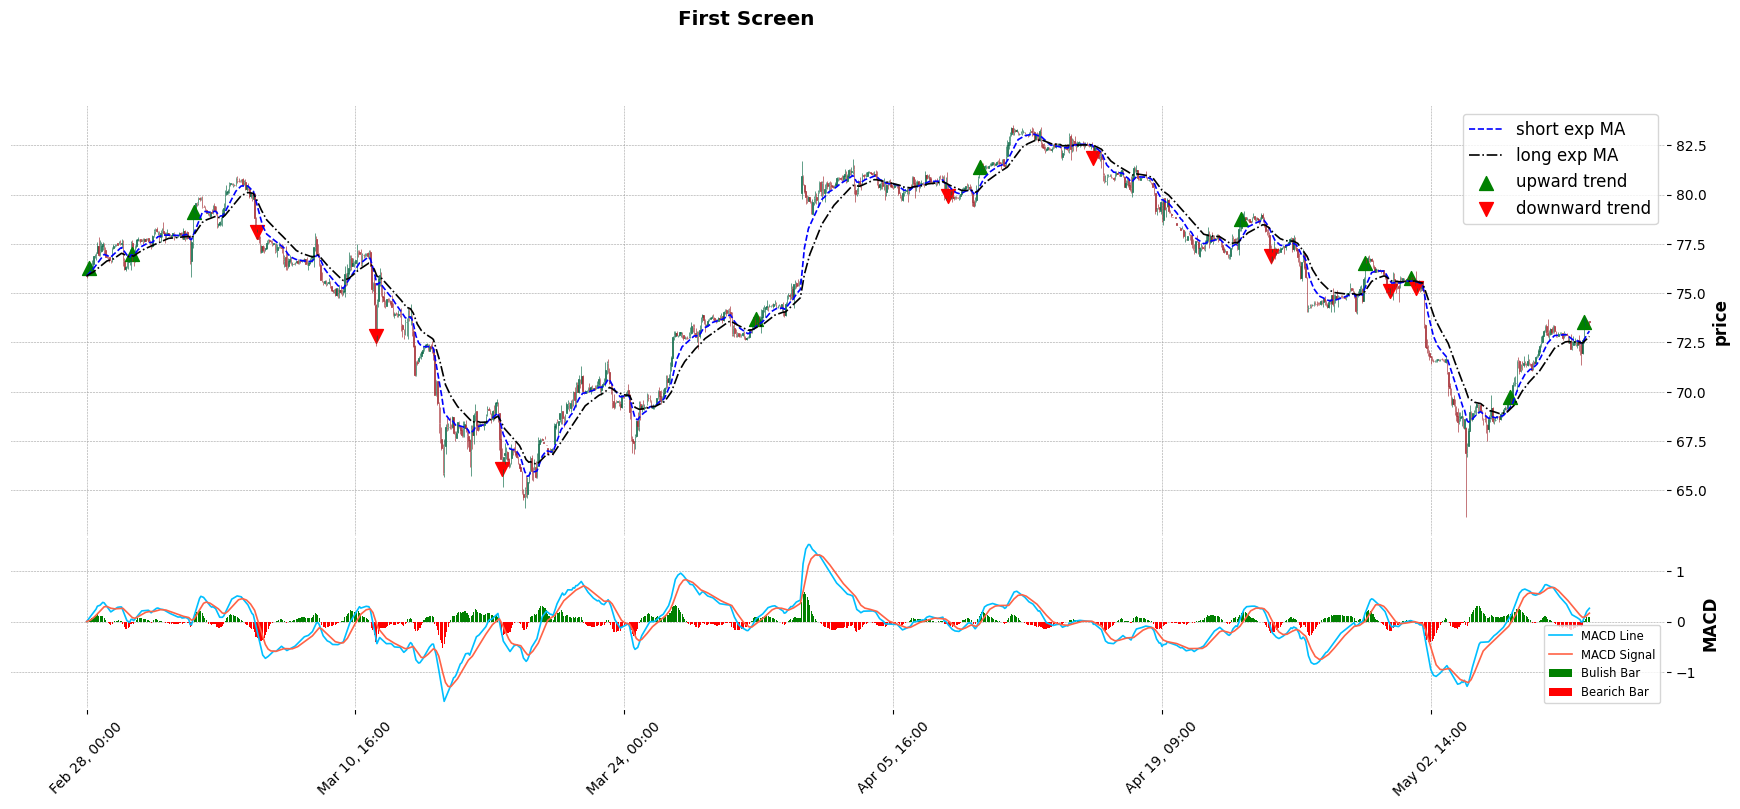

In [13]:
oil_macd['date'] = pd.to_datetime(oil_macd.index)
buy = oil_macd[oil_macd.Position == 1]
buy1 = oil_macd[['date']].merge(buy,how='outer')

sell = oil_macd[oil_macd.Position == -1]
sell1 = oil_macd[['date']].merge(sell,how='outer')

adplot = {'short exp MA': fplt.make_addplot(oil_macd.short_exp, color = 'b', width = 1.2, linestyle='--', panel=0),
          'long exp MA': fplt.make_addplot(oil_macd.long_exp, color = 'k', width = 1.2 ,linestyle='dashdot', panel=0),
          'upward trend': fplt.make_addplot(buy1.Close , type ="scatter", color = 'g', markersize = 100, marker ='^',panel=0),
          'downward trend': fplt.make_addplot(sell1.Close, type = 'scatter', color = 'r', markersize = 100 , marker = 'v',panel=0),
          'MACD Line': fplt.make_addplot(oil_macd.macd_line, color = 'deepskyblue', width = 1.2, panel= 1, ylabel ='MACD',secondary_y= False),
          'MACD Signal': fplt.make_addplot(oil_macd.macd_signal, color = 'tomato', width = 1.2, panel = 1,secondary_y=False),
          'Bulish Bar': fplt.make_addplot(oil_macd.macd_hist.map(lambda x : x if x > 0 else 0), type = 'bar', color ='g', panel = 1,secondary_y=False),
          'Bearich Bar': fplt.make_addplot(oil_macd.macd_hist.map(lambda x : x if x < 0 else 0), type = 'bar', color = 'r', panel = 1,secondary_y=False)}

fig, axes = fplt.plot(oil_macd,
            type= 'candle',
            addplot = list(adplot.values()),
            ylabel = 'price',
            title = 'First Screen',
            style='charles',
            figratio=(8,3),
            figscale=1.5,
            returnfig=True)

axes[0].legend([None]*(len(adplot) + 2))
handles = axes[0].get_legend().legendHandles
axes[0].legend(handles=handles[2:], labels=list(adplot.keys()), loc='upper right', fontsize='large')

axes[2].legend([None]*(len(adplot)+ 2))
handles1 = axes[2].get_legend().legendHandles
axes[2].legend(handles=handles1[0:], labels=list(adplot.keys())[4:], loc='lower right', fontsize='small')

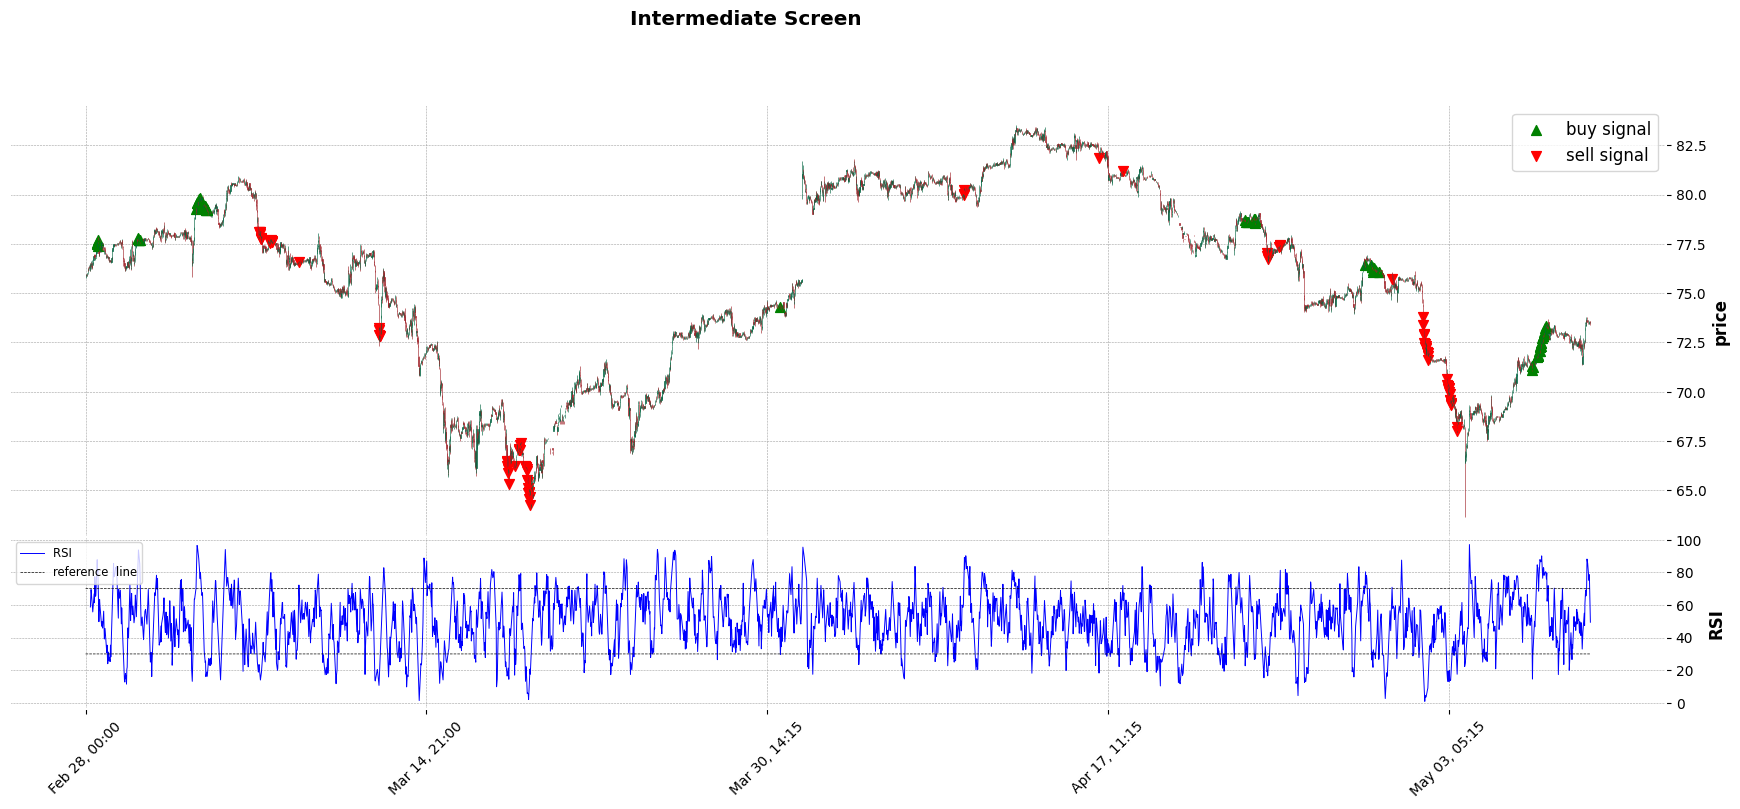

In [14]:
oil_rsi['date'] = pd.to_datetime(oil_rsi.index)
buy = oil_rsi[oil_rsi.Position == 1]
buy1 = oil_rsi[['date']].merge(buy,how='outer')

sell = oil_rsi[oil_rsi.Position == -1]
sell1 = oil_rsi[['date']].merge(sell,how='outer')

oil_rsi['up line']= 70 
oil_rsi['down line']= 30 

adplot = {'buy signal': fplt.make_addplot(buy1.Close, type = 'scatter', color = 'g', markersize = 50 , marker = '^'),
          'sell signal': fplt.make_addplot(sell1.Close, type = 'scatter', color = 'r', markersize = 50, marker = 'v'),
          'RSI ': fplt.make_addplot(oil_rsi['RSI'] , color = 'b', width = 0.7, panel = 1, ylabel ='RSI'),
          'reference  line': fplt.make_addplot(oil_rsi['up line'], color ='k', width = 0.5, linestyle = '--',panel = 1),
          'reference line': fplt.make_addplot(oil_rsi['down line'], color ='k',  width = 0.5, linestyle = '--', panel = 1)}

fig, axes = fplt.plot(oil_rsi,
            type= 'candle',
            addplot = list(adplot.values()),
            ylabel = 'price',
            style='charles',
            figratio=(8,3),
            figscale=1.5,
            returnfig=True,
            title ='Intermediate Screen')

axes[0].legend([None]*(len(adplot) + 2))
handles = axes[0].get_legend().legendHandles
axes[0].legend(handles=handles[2:], labels=list(adplot.keys()), loc='upper right', fontsize='large')

axes[2].legend([None]*(len(adplot)+ 2))
handles1 = axes[2].get_legend().legendHandles
axes[2].legend(handles=handles1[0:], labels=list(adplot.keys())[2:4], loc='upper left', fontsize='small')

#Backtesting Strategy 

In [15]:
class first_screen:

  def __init__(self, symbol,interval):
    self.symbol = symbol
    self.interval = interval
    self.df = yf.Ticker(self.symbol).history(period='60d',
                                     interval= self.interval,
                                     actions=True,auto_adjust=True)  
    if self.interval == '1h':
      self.macd_indicator()
      self.macd_signal()
    else : None 

  def macd_indicator(self):
    self.df['short_exp']   = self.df.Close.ewm(span= 12, adjust= False).mean()
    self.df['long_exp']    = self.df.Close.ewm(span= 26, adjust= False).mean()
    self.df['macd_line']   = self.df['short_exp']-self.df['long_exp']
    self.df['macd_signal'] = self.df['macd_line'].ewm(span = 9 , adjust= False).mean()
    self.df['macd_hist']   = self.df['macd_line'] - self.df['macd_signal']
  
  def macd_signal(self):
    self.df['Position'] = None

    for i in range(2,len(self.df)):
      if  ((self.df.short_exp[i-2] <= self.df.long_exp[i-2]) and 
          (self.df.macd_hist[i-1] > self.df.macd_hist[i-2])  and 
          (self.df.short_exp[i-1] >= self.df.long_exp[i-1])  and 
          (self.df.short_exp[i] > self.df.long_exp[i])       and 
          (self.df.macd_hist[i] > self.df.macd_hist[i-1])):
        self.df.Position.iloc[i] = 1 

      elif ((self.df.short_exp[i-2] >= self.df.long_exp[i-2]) and 
           (self.df.macd_hist[i-1] < self.df.macd_hist[i-2])  and 
           (self.df.short_exp[i-1] <= self.df.long_exp[i-1])  and 
           (self.df.short_exp[i] < self.df.long_exp[i])       and 
           (self.df.macd_hist[i] < self.df.macd_hist[i-1])):
        self.df.Position.iloc[i]= -1 

      else: self.df.Position.iloc[i]= 0 

class second_screen(first_screen):

  def __init__(self,symbol,interval, new_interval):
      super().__init__(symbol,interval)
      self.new_interval = new_interval
      self.data = yf.Ticker(self.symbol).history(period='60d',
                                     interval= self.new_interval,
                                     actions=True,auto_adjust=True)
      if new_interval == '15m':
        self.rsi_indicator()
        self.rsi_signal()

      else: None
      
  def rsi_indicator(self):
    diff                  = self.data.Close.diff(1)
    self.data['Gain']     = diff.clip(lower = 0)
    self.data['Loss']     = diff.clip(upper = 0).abs()
    self.data['avr_gain'] = self.data.Gain.rolling(14).mean()
    self.data['avr_loss'] = self.data.Loss.rolling(14).mean()   
    self.data['RSI']      = 100-(100/(1+(self.data.avr_gain/self.data.avr_loss)))
  
  def get_upward_interval(self):
     self.position = self.df.columns.get_loc('Position')
     upward_start = []
     for i in range(len(self.df)):
       if self.df.iloc[i,self.position] == 1 :
         upward_start.append(i)

     upward_end = []
     for i in upward_start:
       self.df1 = self.df.iloc[i:]
       for y in range(len(self.df1)):
         if ((self.df1.Open[y]<= self.df1.short_exp[y]) and
             (self.df1.Close[y] < self.df1.short_exp[y])):
           upward_end.append(y+i)
           break  
     return upward_start, upward_end 

  def get_downward_interval(self):
    downward_start = []
    for i in range(len(self.df)):
      if self.df.iloc[i,self.position] == -1 :
        downward_start.append(i)

    downward_end = []
    for i in downward_start:
      self.df2 = self.df.iloc[i:]
      for y in range(len(self.df2)):
        if ((self.df2.Open[y] >= self.df2.short_exp[y]) and
            (self.df2.Close[y] > self.df2.short_exp[y])):
          downward_end.append(y+i)
          break
    return  downward_start, downward_end

  def rsi_signal(self):
    self.data['Position'] = None
    a,b = self.get_upward_interval()
    x,y = self.get_downward_interval()

    for start, end in zip(a,b):
      self.df_up = self.data.loc[self.df.iloc[start:end].index[0] : self.df.iloc[start:end].index[-1]] 
      for i in range(len(self.df_up)):
        # oversold 
        if i < len(self.df_up['RSI']):
          if ((self.df_up['RSI'][i] < 30) or (self.df_up['RSI'][i] > 80)) :
            self.data.Position.loc[self.df_up.iloc[i:].index[0]] = 1
      
    for start , end in zip(x,y):
      self.df_down = self.data.loc[self.df.iloc[start:end].index[0] : self.df.iloc[start:end].index[-1]] 
      for i in range(len(self.df_down)):
        # overbought
        if i < len(self.df_down['RSI']):
          if ((self.df_down['RSI'][i] > 70) or (self.df_down['RSI'][i] < 20)) :
            self.data.Position.loc[self.df_down.iloc[i:].index[0]] = -1

df_strategy = second_screen('CL=F','1h','15m').data.copy()
df_strategy.Position = df_strategy.Position.fillna(0)
def SIGNAL():
    return df_strategy.Position


class  triple_screen(Strategy):
  def init(self):
    super().init()
    self.signal = self.I(SIGNAL)
    self.cooldown = 0
  def next(self):
    super().next()
    price = self.data.Close[-1]

    if self.signal == 1 and self.cooldown == 0:
      self.buy(tp = 1.2*price , sl = 0.95*price, size = 0.2)
      self.cooldown = 3   # new trades can be taken only after 3 bars 

    elif self.signal== -1 and self.cooldown == 0:
      self.sell(tp = 0.8*price , sl = 1.05*price, size = 0.2)
      self.cooldown = 3  # new trades can be taken only after 3 bars

    if self.cooldown > 0 : 
      self.cooldown -= 1

In [19]:
bt = Backtest(df_strategy,triple_screen,cash=100000,commission=0.001, exclusive_orders=True)
stat = bt.run()
evaluation = pd.DataFrame(stat)
evaluation

,0
Start,2023-02-28 00:00:00-05:00
End,2023-05-09 19:30:00-04:00
Duration,70 days 18:30:00
Exposure Time [%],81.760722
Equity Final [$],104553.691884
Equity Peak [$],105125.265046
Return [%],4.553692
Buy & Hold Return [%],-3.10649
Return (Ann.) [%],20.754907
Volatility (Ann.) [%],7.916872


In [20]:
bt.plot()

Row(id='3909', ...)

In [21]:
pd.DataFrame(stat['_trades'])

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,257,33,36,77.577500,77.410004,-43.046559,-0.002159,2023-02-28 08:15:00-05:00,2023-02-28 09:00:00-05:00,0 days 00:45:00
1,257,36,155,77.487414,77.790001,77.764923,0.003905,2023-02-28 09:00:00-05:00,2023-03-01 15:45:00-05:00,1 days 06:45:00
2,256,155,158,77.867791,77.690002,-45.513850,-0.002283,2023-03-01 15:45:00-05:00,2023-03-01 16:30:00-05:00,0 days 00:45:00
3,257,158,326,77.767692,79.260002,383.523591,0.019189,2023-03-01 16:30:00-05:00,2023-03-03 12:30:00-05:00,1 days 20:00:00
4,253,326,329,79.339262,79.580002,60.907142,0.003034,2023-03-03 12:30:00-05:00,2023-03-03 13:15:00-05:00,0 days 00:45:00
...,...,...,...,...,...,...,...,...,...,...
68,288,4278,4281,72.412336,72.500000,25.247136,0.001211,2023-05-08 03:45:00-04:00,2023-05-08 04:30:00-04:00,0 days 00:45:00
69,287,4281,4286,72.572500,72.830002,73.903026,0.003548,2023-05-08 04:30:00-04:00,2023-05-08 05:45:00-04:00,0 days 01:15:00
70,286,4286,4290,72.902832,73.040001,39.230358,0.001882,2023-05-08 05:45:00-04:00,2023-05-08 06:45:00-04:00,0 days 01:00:00
71,285,4290,4293,73.113041,73.239998,36.182730,0.001736,2023-05-08 06:45:00-04:00,2023-05-08 07:30:00-04:00,0 days 00:45:00


**Thank you for reading!
Please let me know if you have any feedback. 🙂
Should you need further trading strategies, please feel free to contact me at achraf.benssassi@gmail.com**